# Research Recap on Stress Detection

### Outline on what to do

---

1. Dataset
    - Gunakan UBFC-Phys: memiliki dua kondisi (rest dan arithmetic task)

2. Ekstraksi Sinyal rPPG
    - Gunakan metode video-based rPPG (ICA/POS/CHROM/GREEN/OMIT)
    - Hasilkan estimasi Pulse Rate (HR) per detik

3. Validasi rPPG terhadap Ground Truth
    - Bandingkan HR dari rPPG dengan HR dari PPG (ground truth)

        Hitung:
        - Pearson correlation
        - MAE / RMSE

4. Analisis Perbedaan Kondisi (Rest vs Task)
    - Hitung HR rata-rata saat rest dan task per subjek

        Lakukan:

        - Paired t-test atau Wilcoxon pada HR
        - Hitung delta dan % perubahan
        - Laporkan berapa persen subjek mengalami peningkatan HR saat task

5. Penentuan Threshold untuk Deteksi Stres
    - Gunakan rata-rata perubahan atau cutoff statistik (misal, +10%)
    - Threshold ini akan digunakan untuk deteksi real-time
    - Diskusikan bahwa HRV tidak digunakan karena akurasinya buruk (justified by correlation & error)



In [139]:
## Importing Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
import scipy
import os
from prettytable import PrettyTable

# Storing the Signals
We will working with the most of the UBFC-Phys signals for each scenario.
All methods will be done under the rPPG-Toolbox kit.

There's 4 scenario with different state
- Rest with FaceDetector
- Task with FaceDetector
- Rest with FaceLandmark
- Task with FaceLandmark

### List of signals and it's compsition
Rest (Task 1) / stress (Task 3) state:
- POS
- Green
- Chrom
- OMIT
- LGI


In [140]:
def preprocess_ppg(signal, fs = 35):
    """ Computes the Preprocessed PPG Signal, this steps include the following:
        1. Moving Average Smoothing
        2. Bandpass Filtering
        
        Parameters:
        ----------
        signal (numpy array): 
            The PPG Signal to be preprocessed
        fs (float): 
            The Sampling Frequency of the Signal
            
        Returns:
        --------
        numpy array: 
            The Preprocessed PPG Signal
    
    """ 

    # 2. Bandpass filter to isolate the cardiac component (0.4-2.5 Hz)
    b_bp, a_bp = scipy.signal.butter(3, [0.7, 2.5], btype='band', fs=fs)
    filtered = scipy.signal.filtfilt(b_bp, a_bp, signal)
    
    return filtered

### Scenario 1: Extracting the rPPG with the FaceDetector (Rest State)

---

In [141]:
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56"]
tasks = ["T1"]

# Store ground truth and rPPG data
rest_face_detector_gt_data = {}
rest_face_detector_rppg_data = {
    'POS': {},
    'LGI': {},
    'OMIT': {},
    'GREEN': {},
    'CHROM': {}
}
# Expected sampling rates (adjust if different for your dataset)
sample_rate_gt = 64  # Hz
sample_rate_video = 35 # Hz


In [142]:
for subject in subjects:
    for task in tasks:
        subject_task_id = f"{subject}_{task}"

        # Load rPPG signals from different methods
        pos = np.load(os.path.join(root_path, subject, f"{subject}_{task}_POS_rppg.npy"))
        lgi = np.load(os.path.join(root_path, subject, f"{subject}_{task}_LGI_rppg.npy"))
        omit = np.load(os.path.join(root_path, subject, f"{subject}_{task}_OMIT_rppg.npy"))
        green = np.load(os.path.join(root_path, subject, f"{subject}_{task}_GREEN_rppg.npy"))
        chrom = np.load(os.path.join(root_path, subject, f"{subject}_{task}_CHROM_rppg.npy"))

        # Load ground truth BVP
        GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
        GT = GT.flatten()

        ## process rPPG signals
        rest_face_detector_rppg_data["POS"][subject_task_id] = preprocess_ppg(pos, fs=sample_rate_video)
        rest_face_detector_rppg_data["LGI"][subject_task_id] = preprocess_ppg(lgi, fs=sample_rate_video)
        rest_face_detector_rppg_data["OMIT"][subject_task_id] = preprocess_ppg(omit, fs=sample_rate_video)
        rest_face_detector_rppg_data["GREEN"][subject_task_id] = preprocess_ppg(green, fs=sample_rate_video)
        rest_face_detector_rppg_data["CHROM"][subject_task_id] = preprocess_ppg(chrom, fs=sample_rate_video)
        
        GT = preprocess_ppg(GT, fs=sample_rate_gt)
        rest_face_detector_gt_data[subject_task_id] = GT

        ## process rPPG signals
        # pos, _ = nk.ppg_process(pos, sampling_rate=sample_rate_video)
        # lgi, _ = nk.ppg_process(lgi, sampling_rate=sample_rate_video)
        # omit, _ = nk.ppg_process(omit, sampling_rate=sample_rate_video)
        # green, _ = nk.ppg_process(green, sampling_rate=sample_rate_video)
        # chrom, _ = nk.ppg_process(chrom, sampling_rate=sample_rate_video)
        # GT, _ = nk.ppg_process(GT, sampling_rate=sample_rate_gt)

        # rest_face_detector_rppg_data["POS"][subject_task_id] = pos["PPG_Clean"]
        # rest_face_detector_rppg_data["LGI"][subject_task_id] = lgi["PPG_Clean"]
        # rest_face_detector_rppg_data["OMIT"][subject_task_id] = omit["PPG_Clean"]
        # rest_face_detector_rppg_data["GREEN"][subject_task_id] = green["PPG_Clean"]
        # rest_face_detector_rppg_data["CHROM"][subject_task_id] = chrom["PPG_Clean"]
        
        # rest_face_detector_gt_data[subject_task_id] = GT["PPG_Clean"]

    



### Scenario 2: Extracting the rPPG with the FaceLandmarker (Rest State)

---

In [143]:
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56"]
tasks = ["T1"]

# Store ground truth and rPPG data
rest_face_landmarker_gt_data = {}
rest_face_landmarker_rppg_data = {
    'POS': {},
    'LGI': {},
    'OMIT': {},
    'GREEN': {},
    'CHROM': {}
}
# Expected sampling rates (adjust if different for your dataset)
sample_rate_gt = 64  # Hz
sample_rate_video = 35 # Hz


In [144]:
for subject in subjects:
    for task in tasks:
        subject_task_id = f"{subject}_{task}"

        # Load rPPG signals from different methods
        pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
        lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
        omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
        green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
        chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))

        # Load ground truth BVP
        GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
        GT = GT.flatten()

        ## process rPPG signals
        rest_face_landmarker_rppg_data["POS"][subject_task_id] = preprocess_ppg(pos, fs=sample_rate_video)
        rest_face_landmarker_rppg_data["LGI"][subject_task_id] = preprocess_ppg(lgi, fs=sample_rate_video)
        rest_face_landmarker_rppg_data["OMIT"][subject_task_id] = preprocess_ppg(omit, fs=sample_rate_video)
        rest_face_landmarker_rppg_data["GREEN"][subject_task_id] = preprocess_ppg(green, fs=sample_rate_video)
        rest_face_landmarker_rppg_data["CHROM"][subject_task_id] = preprocess_ppg(chrom, fs=sample_rate_video)
        
        GT = preprocess_ppg(GT, fs=sample_rate_gt)
        rest_face_landmarker_gt_data[subject_task_id] = GT

        ## process rPPG signals
        # pos, _ = nk.ppg_process(pos, sampling_rate=sample_rate_video)
        # lgi, _ = nk.ppg_process(lgi, sampling_rate=sample_rate_video)
        # omit, _ = nk.ppg_process(omit, sampling_rate=sample_rate_video)
        # green, _ = nk.ppg_process(green, sampling_rate=sample_rate_video)
        # chrom, _ = nk.ppg_process(chrom, sampling_rate=sample_rate_video)
        # GT, _ = nk.ppg_process(GT, sampling_rate=sample_rate_gt)

        # rest_face_landmarker_rppg_data["POS"][subject_task_id] = pos["PPG_Clean"]
        # rest_face_landmarker_rppg_data["LGI"][subject_task_id] = lgi["PPG_Clean"]
        # rest_face_landmarker_rppg_data["OMIT"][subject_task_id] = omit["PPG_Clean"]
        # rest_face_landmarker_rppg_data["GREEN"][subject_task_id] = green["PPG_Clean"]
        # rest_face_landmarker_rppg_data["CHROM"][subject_task_id] = chrom["PPG_Clean"]
        
        # rest_face_landmarker_gt_data[subject_task_id] = GT["PPG_Clean"]



### Scenario 3: Extracting the rPPG with the FaceDetector (Stress State)

---

In [145]:
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56"]
tasks = ["T3"]

# Store ground truth and rPPG data
task_face_detector_gt_data = {}
task_face_detector_rppg_data = {
    'POS': {},
    'LGI': {},
    'OMIT': {},
    'GREEN': {},
    'CHROM': {}
}
# Expected sampling rates (adjust if different for your dataset)
sample_rate_gt = 64  # Hz
sample_rate_video = 35 # Hz


In [146]:
for subject in subjects:
    for task in tasks:
        subject_task_id = f"{subject}_{task}"

        # Load rPPG signals from different methods
        pos = np.load(os.path.join(root_path, subject, f"{subject}_{task}_POS_rppg.npy"))
        lgi = np.load(os.path.join(root_path, subject, f"{subject}_{task}_LGI_rppg.npy"))
        omit = np.load(os.path.join(root_path, subject, f"{subject}_{task}_OMIT_rppg.npy"))
        green = np.load(os.path.join(root_path, subject, f"{subject}_{task}_GREEN_rppg.npy"))
        chrom = np.load(os.path.join(root_path, subject, f"{subject}_{task}_CHROM_rppg.npy"))

        # Load ground truth BVP
        GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
        GT = GT.flatten()

        ## process rPPG signals
        task_face_detector_rppg_data["POS"][subject_task_id] = preprocess_ppg(pos, fs=sample_rate_video)
        task_face_detector_rppg_data["LGI"][subject_task_id] = preprocess_ppg(lgi, fs=sample_rate_video)
        task_face_detector_rppg_data["OMIT"][subject_task_id] = preprocess_ppg(omit, fs=sample_rate_video)
        task_face_detector_rppg_data["GREEN"][subject_task_id] = preprocess_ppg(green, fs=sample_rate_video)
        task_face_detector_rppg_data["CHROM"][subject_task_id] = preprocess_ppg(chrom, fs=sample_rate_video)
        
        GT = preprocess_ppg(GT, fs=sample_rate_gt)
        task_face_detector_gt_data[subject_task_id] = GT

        ## process rPPG signals
        # pos, _ = nk.ppg_process(pos, sampling_rate=sample_rate_video)
        # lgi, _ = nk.ppg_process(lgi, sampling_rate=sample_rate_video)
        # omit, _ = nk.ppg_process(omit, sampling_rate=sample_rate_video)
        # green, _ = nk.ppg_process(green, sampling_rate=sample_rate_video)
        # chrom, _ = nk.ppg_process(chrom, sampling_rate=sample_rate_video)
        # GT, _ = nk.ppg_process(GT, sampling_rate=sample_rate_gt)

        # task_face_detector_rppg_data["POS"][subject_task_id] = pos["PPG_Clean"]
        # task_face_detector_rppg_data["LGI"][subject_task_id] = lgi["PPG_Clean"]
        # task_face_detector_rppg_data["OMIT"][subject_task_id] = omit["PPG_Clean"]
        # task_face_detector_rppg_data["GREEN"][subject_task_id] = green["PPG_Clean"]
        # task_face_detector_rppg_data["CHROM"][subject_task_id] = chrom["PPG_Clean"]
        
        # task_face_detector_gt_data[subject_task_id] = GT["PPG_Clean"]


### Scenario 4: Extracting the rPPG with the FaceLandmarker (Stress State)

---

In [147]:
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56"]
tasks = ["T3"]

# Store ground truth and rPPG data
task_face_landmarker_gt_data = {}
task_face_landmarker_rppg_data = {
    'POS': {},
    'LGI': {},
    'OMIT': {},
    'GREEN': {},
    'CHROM': {}
}
# Expected sampling rates (adjust if different for your dataset)
sample_rate_gt = 64  # Hz
sample_rate_video = 35 # Hz


In [148]:
for subject in subjects:
    for task in tasks:
        subject_task_id = f"{subject}_{task}"

        # Load rPPG signals from different methods
        pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
        lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
        omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
        green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
        chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))

        # Load ground truth BVP
        GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
        GT = GT.flatten()

        ## process rPPG signals
        task_face_landmarker_rppg_data["POS"][subject_task_id] = preprocess_ppg(pos, fs=sample_rate_video)
        task_face_landmarker_rppg_data["LGI"][subject_task_id] = preprocess_ppg(lgi, fs=sample_rate_video)
        task_face_landmarker_rppg_data["OMIT"][subject_task_id] = preprocess_ppg(omit, fs=sample_rate_video)
        task_face_landmarker_rppg_data["GREEN"][subject_task_id] = preprocess_ppg(green, fs=sample_rate_video)
        task_face_landmarker_rppg_data["CHROM"][subject_task_id] = preprocess_ppg(chrom, fs=sample_rate_video)
        
        GT = preprocess_ppg(GT, fs=sample_rate_gt)
        task_face_landmarker_gt_data[subject_task_id] = GT

        ## process rPPG signals
        # pos, _ = nk.ppg_process(pos, sampling_rate=sample_rate_video)
        # lgi, _ = nk.ppg_process(lgi, sampling_rate=sample_rate_video)
        # omit, _ = nk.ppg_process(omit, sampling_rate=sample_rate_video)
        # green, _ = nk.ppg_process(green, sampling_rate=sample_rate_video)
        # chrom, _ = nk.ppg_process(chrom, sampling_rate=sample_rate_video)
        # GT, _ = nk.ppg_process(GT, sampling_rate=sample_rate_gt)

        # task_face_landmarker_rppg_data["POS"][subject_task_id] = pos["PPG_Clean"]
        # task_face_landmarker_rppg_data["LGI"][subject_task_id] = lgi["PPG_Clean"]
        # task_face_landmarker_rppg_data["OMIT"][subject_task_id] = omit["PPG_Clean"]
        # task_face_landmarker_rppg_data["GREEN"][subject_task_id] = green["PPG_Clean"]
        # task_face_landmarker_rppg_data["CHROM"][subject_task_id] = chrom["PPG_Clean"]
        
        # task_face_landmarker_gt_data[subject_task_id] = GT["PPG_Clean"]


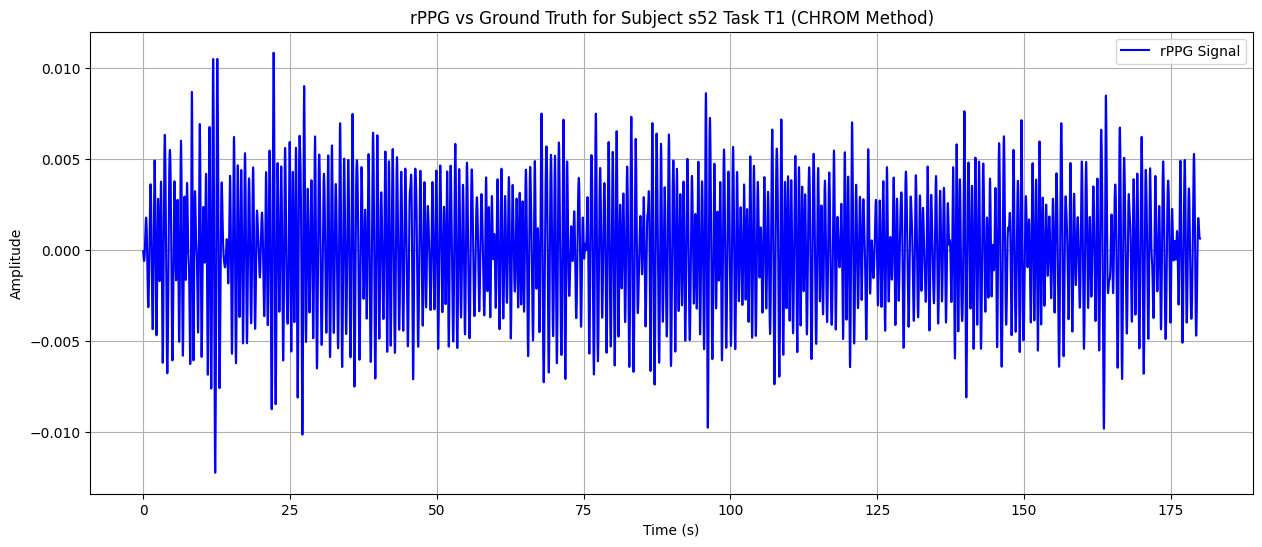

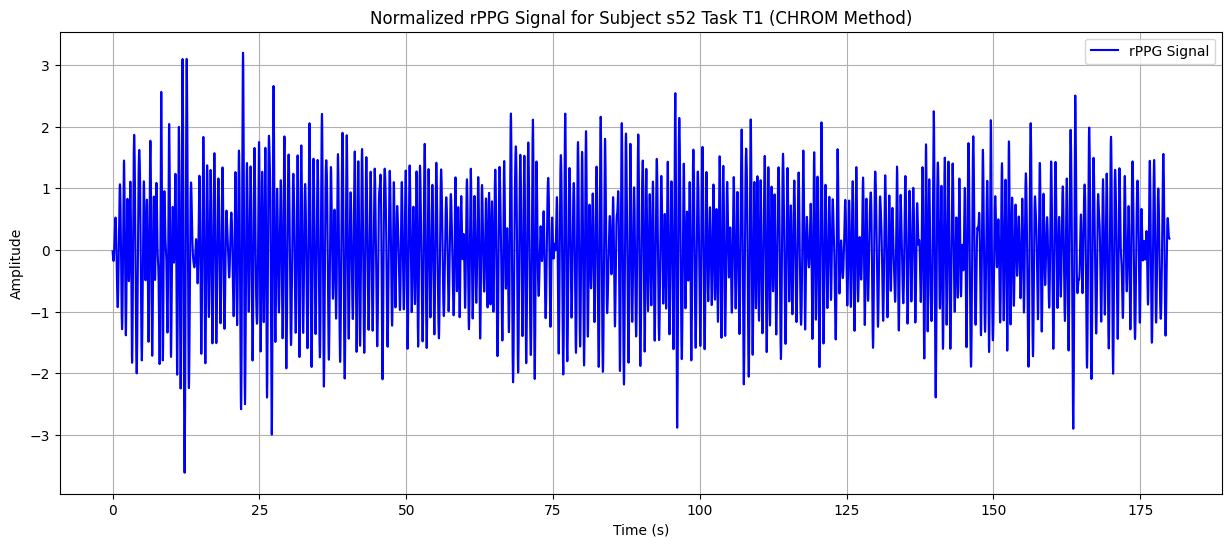

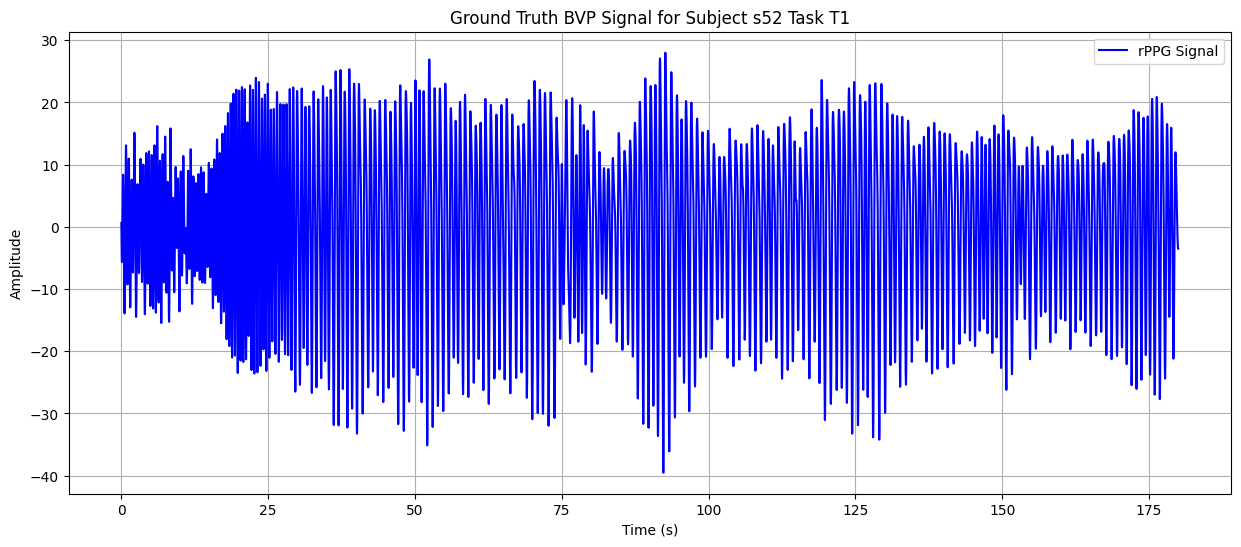

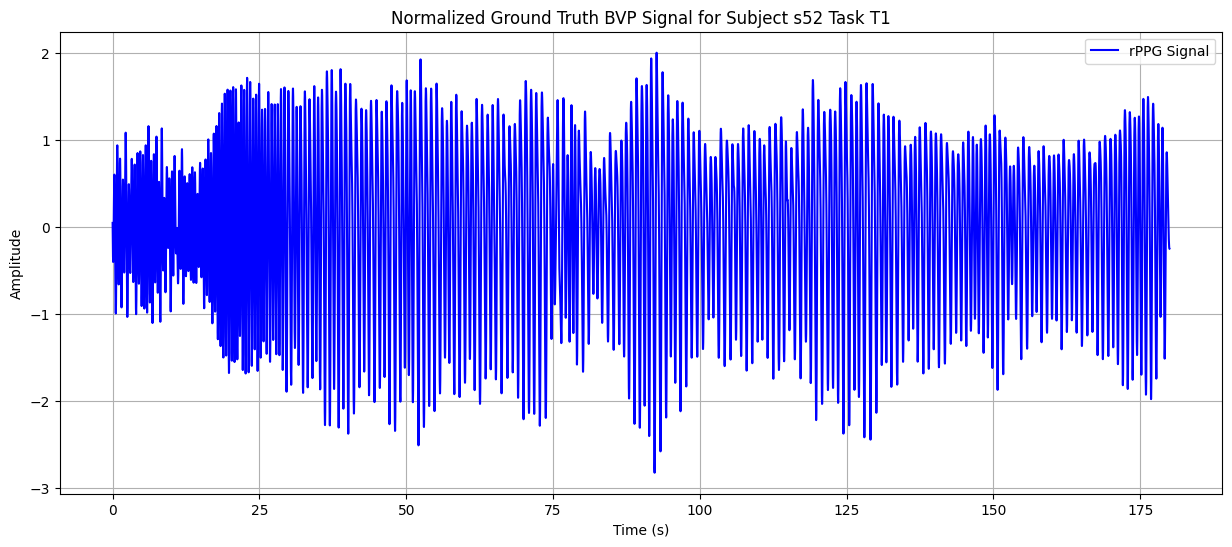

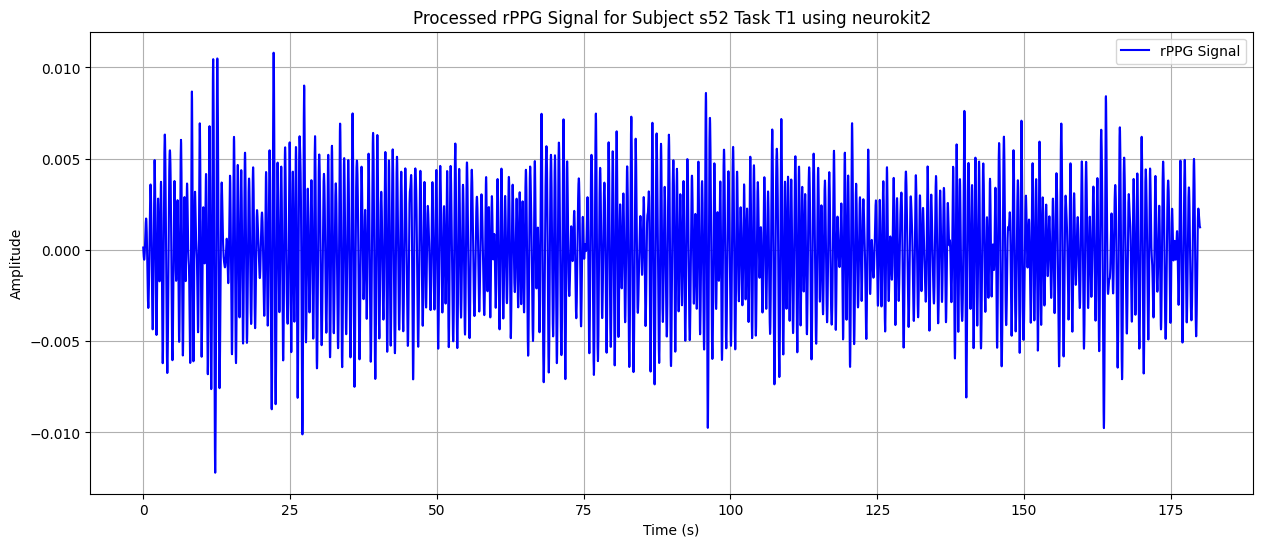

In [149]:
## Plot rppg signals and ground truth for visual inspection
def plot_signals(rppg_signal, fs, title):
    time_rppg = np.arange(len(rppg_signal)) / fs
    # time_gt = np.arange(len(gt_signal)) / fs
    
    plt.figure(figsize=(15, 6))
    plt.plot(time_rppg, rppg_signal, label='rPPG Signal', color='blue')
    # plt.plot(time_gt, gt_signal, label='Ground Truth BVP', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()


# Example of plotting rPPG and ground truth for one of the methods
plot_signals(rest_face_detector_rppg_data['CHROM']['s52_T1'], 
             sample_rate_video, 
             'rPPG vs Ground Truth for Subject s52 Task T1 (CHROM Method)')

# Normalize the signals
def normalize_signal(signal):
    """ Normalize the signal to have zero mean and unit variance """
    return (signal - np.mean(signal)) / np.std(signal)

# Example of normalizing and plotting rPPG signal
normalized_rppg_signal = normalize_signal(rest_face_detector_rppg_data['CHROM']['s52_T1'])
plot_signals(normalized_rppg_signal, sample_rate_video, 
             'Normalized rPPG Signal for Subject s52 Task T1 (CHROM Method)')

# Plot the GT
plot_signals(rest_face_landmarker_gt_data['s52_T1'],
                sample_rate_gt, 
                'Ground Truth BVP Signal for Subject s52 Task T1')

# Normalize the ground truth signal
normalized_gt_signal = normalize_signal(rest_face_landmarker_gt_data['s52_T1'])
plot_signals(normalized_gt_signal, sample_rate_gt,
                'Normalized Ground Truth BVP Signal for Subject s52 Task T1')

## Process using neurokit2 ppg_process  
signals_rppg, _ = nk.ppg_process(rest_face_detector_rppg_data['CHROM']['s52_T1'], sampling_rate=sample_rate_video)
plot_signals(signals_rppg['PPG_Clean'], sample_rate_video,
                'Processed rPPG Signal for Subject s52 Task T1 using neurokit2')


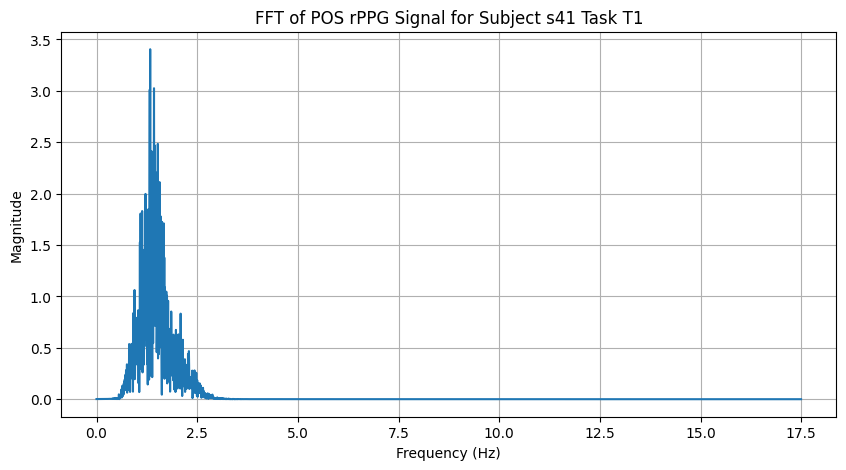

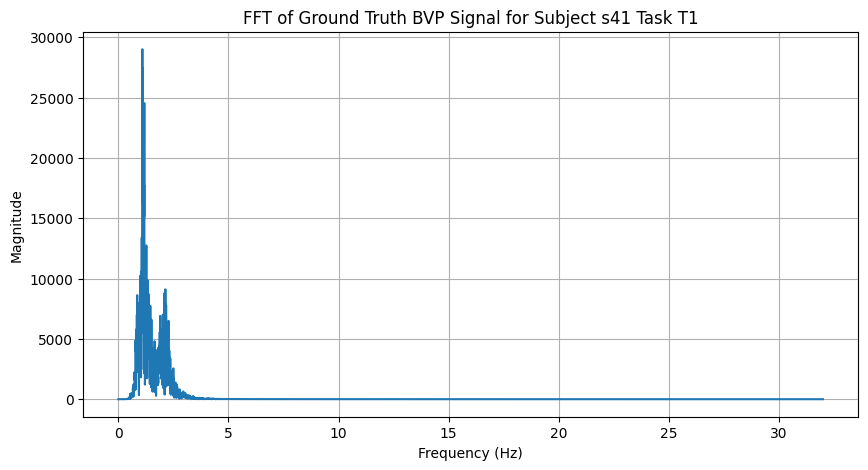

In [150]:
## Check the FFT of any signals if already being processed
def plot_fft(signal, fs, title):
    freqs = np.fft.fftfreq(len(signal), 1/fs)
    fft_values = np.abs(np.fft.fft(signal))
    
    plt.figure(figsize=(10, 5))
    plt.plot(freqs[:len(freqs)//2], fft_values[:len(fft_values)//2])
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.show()

# Example of plotting FFT for one of the rPPG methods
plot_fft(rest_face_detector_rppg_data['CHROM']['s52_T1'], sample_rate_video, 'FFT of POS rPPG Signal for Subject s41 Task T1')
# Example of plotting FFT for ground truth BVP
plot_fft(rest_face_detector_gt_data['s52_T1'], sample_rate_gt, 'FFT of Ground Truth BVP Signal for Subject s41 Task T1')

---
 
### Calculate the MAE / RMSE between FaceDetector vs FaceLandmaker

Compute the correlation between the MAE / RMSE between the FaceDetector vs FaceLandmaker for same state

In [151]:
## MAE / RMSE for rest state
def calculate_mae_rmse(gt, rppg):
    """ Calculate Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) between ground truth and rPPG signals.
    
    Parameters:
    ----------
    gt (numpy array): Ground truth BVP signal.
    rppg (numpy array): rPPG signal to compare against the ground truth.
    
    Returns:
    -------
    tuple: (rppg_hr, gt_hr, mae, rmse)
    """
    
    # Standardize the signals for better peak detection
    gt_norm = (gt - np.mean(gt)) / np.std(gt)
    rppg_norm = (rppg - np.mean(rppg)) / np.std(rppg)

    # Calculate the heart rates
    peaks_gt, _ = scipy.signal.find_peaks(gt_norm, prominence=0.5)
    gt_hr = int(np.mean(60 / (np.diff(peaks_gt) / sample_rate_gt)))
    
    peaks_rppg, _ = scipy.signal.find_peaks(rppg_norm, prominence=0.5)
    rppg_hr = int(np.mean(60 / (np.diff(peaks_rppg) / sample_rate_video)))
    
    # Calculate errors between the two heart rates
    mae = int(np.mean(np.abs(gt_hr - rppg_hr)))  # Simple absolute difference
    
    return rppg_hr, gt_hr, mae

### Scenario 1 : Comparing the MAE / RMSE on the Rest State on FaceDetector

---

In [152]:
# Create a dictionary to store results for each subject and method
results_dict = {}

# Iterate through the rPPG methods and calculate MAE and RMSE
for method, data in rest_face_detector_rppg_data.items():
    for subject_task_id, rppg_signal in data.items():
        gt_signal = rest_face_detector_gt_data[subject_task_id]
        rppg_hr, gt_hr, mae = calculate_mae_rmse(gt_signal, rppg_signal)
        
        # Initialize dict for this subject if it doesn't exist yet
        if subject_task_id not in results_dict:
            results_dict[subject_task_id] = {"GT": gt_hr}
        
        # Store results for this method
        results_dict[subject_task_id][f"{method}_HR"] = rppg_hr
        results_dict[subject_task_id][f"{method}_MAE"] = mae


In [153]:
# Display the results in a table format
table = PrettyTable()
table.field_names = ["Subject", "GT", 
                     "POS HR", "POS MAE", 
                     "GREEN HR", "GREEN MAE",
                     "LGI HR", "LGI MAE", 
                     "OMIT HR", "OMIT MAE", 
                     "CHROM HR", "CHROM MAE"]

# Now create rows from the collected data
for subject_task_id, result in results_dict.items():
    row = [subject_task_id, result.get("GT", "N/A")]
    
    # Add data for each method
    for method in ["POS", "GREEN", "LGI", "OMIT", "CHROM"]:
        hr = result.get(f"{method}_HR", "N/A")
        mae = result.get(f"{method}_MAE", "N/A")
                
        # Add to row
        row.append(hr)
        row.append(mae)
    
    # Add
    table.add_row(row)
               
# Calculate the group-level analysis trends
for method in ['POS', 'GREEN', 'LGI', 'OMIT', 'CHROM']:
    hr_values = []
    mae_values = []
    rmse_values = []
    
    for subject_task_id, result in results_dict.items():
        hr = result.get(f"{method}_HR", None)
        mae = result.get(f"{method}_MAE", None)
        # Compute the rmse since it was the squared error of the mae
        rmse = mae**2
        
        if hr is not None and mae is not None:
            hr_values.append(hr)
            mae_values.append(mae)
            rmse_values.append(rmse)

    
    # Calculate mean and std for HR, MAE, RMSE
    mean_hr = np.mean(hr_values) if hr_values else 0
    std_hr = np.std(hr_values) if hr_values else 0
    mean_mae = np.mean(mae_values) if mae_values else 0
    std_mae = np.std(mae_values) if mae_values else 0
    mean_rmse = np.sqrt(np.mean(rmse_values)) if rmse_values else 0
    std_rmse = np.sqrt(np.std(rmse_values)) if rmse_values else 0
    
    print(f"{method} - Mean HR: {mean_hr:.2f} ± {std_hr:.2f}, Mean MAE: {mean_mae:.2f} ± {std_mae:.2f}, Mean RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}")

# Print the table
print(table)

POS - Mean HR: 85.06 ± 12.08, Mean MAE: 3.94 ± 5.74, Mean RMSE: 6.96 ± 11.26
GREEN - Mean HR: 82.00 ± 9.44, Mean MAE: 7.38 ± 7.35, Mean RMSE: 10.41 ± 14.26
LGI - Mean HR: 84.19 ± 12.14, Mean MAE: 3.19 ± 5.75, Mean RMSE: 6.57 ± 11.76
OMIT - Mean HR: 84.19 ± 12.14, Mean MAE: 3.19 ± 5.75, Mean RMSE: 6.57 ± 11.76
CHROM - Mean HR: 85.19 ± 11.28, Mean MAE: 4.06 ± 5.70, Mean RMSE: 7.00 ± 11.72
+---------+-----+--------+---------+----------+-----------+--------+---------+---------+----------+----------+-----------+
| Subject |  GT | POS HR | POS MAE | GREEN HR | GREEN MAE | LGI HR | LGI MAE | OMIT HR | OMIT MAE | CHROM HR | CHROM MAE |
+---------+-----+--------+---------+----------+-----------+--------+---------+---------+----------+----------+-----------+
|  s41_T1 |  97 |   97   |    0    |    93    |     4     |   97   |    0    |    97   |    0     |    96    |     1     |
|  s42_T1 |  71 |   72   |    1    |    83    |     12    |   72   |    1    |    72   |    1     |    73    |     2  

### Scenario 2 : Comparing the MAE / RMSE on the Rest State on FaceLandmarker

---

In [154]:
# Create a dictionary to store results for each subject and method
results_dict = {}

# Iterate through the rPPG methods and calculate MAE and RMSE
for method, data in rest_face_landmarker_rppg_data.items():
    for subject_task_id, rppg_signal in data.items():
        gt_signal = rest_face_landmarker_gt_data[subject_task_id]
        rppg_hr, gt_hr, mae = calculate_mae_rmse(gt_signal, rppg_signal)
        
        # Initialize dict for this subject if it doesn't exist yet
        if subject_task_id not in results_dict:
            results_dict[subject_task_id] = {"GT": gt_hr}
        
        # Store results for this method
        results_dict[subject_task_id][f"{method}_HR"] = rppg_hr
        results_dict[subject_task_id][f"{method}_MAE"] = mae
    

In [155]:
# Display the results in a table format
table = PrettyTable()
table.field_names = ["Subject", "GT", 
                     "POS HR", "POS MAE", 
                     "GREEN HR", "GREEN MAE",
                     "LGI HR", "LGI MAE", 
                     "OMIT HR", "OMIT MAE", 
                     "CHROM HR", "CHROM MAE"]

# Now create rows from the collected data
for subject_task_id, result in results_dict.items():
    row = [subject_task_id, result.get("GT", "N/A")]
    
    # Add data for each method
    for method in ["POS", "GREEN", "LGI", "OMIT", "CHROM"]:
        hr = result.get(f"{method}_HR", "N/A")
        mae = result.get(f"{method}_MAE", "N/A")
        
        # Add to row
        row.append(hr)
        row.append(rmse)
    
    # Add
    table.add_row(row)

# Calculate the group-level analysis trends
for method in ['POS', 'GREEN', 'LGI', 'OMIT', 'CHROM']:
    hr_values = []
    mae_values = []
    rmse_values = []
    
    for subject_task_id, result in results_dict.items():
        hr = result.get(f"{method}_HR", None)
        mae = result.get(f"{method}_MAE", None)
        # Compute the rmse since it was the squared error of the mae
        rmse = mae**2
        
        if hr is not None and mae is not None:
            hr_values.append(hr)
            mae_values.append(mae)
            rmse_values.append(rmse)

    
    # Calculate mean and std for HR, MAE, RMSE
    mean_hr = np.mean(hr_values) if hr_values else 0
    std_hr = np.std(hr_values) if hr_values else 0
    mean_mae = np.mean(mae_values) if mae_values else 0
    std_mae = np.std(mae_values) if mae_values else 0
    mean_rmse = np.sqrt(np.mean(rmse_values)) if rmse_values else 0
    std_rmse = np.sqrt(np.std(rmse_values)) if rmse_values else 0
    
    print(f"{method} - Mean HR: {mean_hr:.2f} ± {std_hr:.2f}, Mean MAE: {mean_mae:.2f} ± {std_mae:.2f}, Mean RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}")

# Print the table
print(table)


POS - Mean HR: 81.75 ± 12.47, Mean MAE: 6.50 ± 9.51, Mean RMSE: 11.52 ± 18.17
GREEN - Mean HR: 77.25 ± 11.62, Mean MAE: 8.38 ± 10.27, Mean RMSE: 13.25 ± 19.04
LGI - Mean HR: 81.56 ± 12.78, Mean MAE: 5.56 ± 9.23, Mean RMSE: 10.77 ± 17.37
OMIT - Mean HR: 81.69 ± 12.65, Mean MAE: 5.56 ± 9.00, Mean RMSE: 10.58 ± 16.95
CHROM - Mean HR: 82.31 ± 12.42, Mean MAE: 5.69 ± 8.95, Mean RMSE: 10.60 ± 16.78
+---------+-----+--------+---------+----------+-----------+--------+---------+---------+----------+----------+-----------+
| Subject |  GT | POS HR | POS MAE | GREEN HR | GREEN MAE | LGI HR | LGI MAE | OMIT HR | OMIT MAE | CHROM HR | CHROM MAE |
+---------+-----+--------+---------+----------+-----------+--------+---------+---------+----------+----------+-----------+
|  s41_T1 |  97 |   95   |    64   |    93    |     64    |   96   |    64   |    96   |    64    |    97    |     64    |
|  s42_T1 |  71 |   76   |    64   |    74    |     64    |   75   |    64   |    75   |    64    |    76    |  

### Notes Analysis on the FaceDetector vs FaceLandmarker on Rest State

1. FaceDetector wins across all methods
FD consistently gives lower MAE and lower HR mean error than FL.

Especially large drops in MAE for POS, LGI, OMIT (over 2.4 BPM reduction).

Slightly less pronounced for GREEN and CHROM.

2. This is weird, but the FaceLandmark on Both Left + Right Cheek gives worst result compare to the FaceDetector
One can think that since one cheek is independent from others, when combined, if one is poor, the result is also poor.

I can't do the result testing anymore since it takes longer than I expcedted. So let's proceed from this.


### Scenario 3 : Comparing the MAE / RMSE on the Task State on FaceDetector

---

In [156]:
# Create a dictionary to store results for each subject and method
results_dict = {}

# Iterate through the rPPG methods and calculate MAE and RMSE
for method, data in task_face_detector_rppg_data.items():
    for subject_task_id, rppg_signal in data.items():
        gt_signal = task_face_detector_gt_data[subject_task_id]
        rppg_hr, gt_hr, mae = calculate_mae_rmse(gt_signal, rppg_signal)
        
        # Initialize dict for this subject if it doesn't exist yet
        if subject_task_id not in results_dict:
            results_dict[subject_task_id] = {"GT": gt_hr}
        
        # Store results for this method
        results_dict[subject_task_id][f"{method}_HR"] = rppg_hr
        results_dict[subject_task_id][f"{method}_MAE"] = mae
        results_dict[subject_task_id][f"{method}_RMSE"] = rmse
    

In [157]:
# Display the results in a table format
table = PrettyTable()
table.field_names = ["Subject", "GT", 
                     "POS HR", "POS MAE", 
                     "GREEN HR", "GREEN MAE",
                     "LGI HR", "LGI MAE", 
                     "OMIT HR", "OMIT MAE", 
                     "CHROM HR", "CHROM MAE"]

# Now create rows from the collected data
for subject_task_id, result in results_dict.items():
    row = [subject_task_id, result.get("GT", "N/A")]
    
    # Add data for each method
    for method in ["POS", "GREEN", "LGI", "OMIT", "CHROM"]:
        hr = result.get(f"{method}_HR", "N/A")
        mae = result.get(f"{method}_MAE", "N/A")
        
        # Add to row
        row.append(hr)
        row.append(rmse)
    
    # Add
    table.add_row(row)

# Calculate the group-level analysis trends
for method in ['POS', 'GREEN', 'LGI', 'OMIT', 'CHROM']:
    hr_values = []
    mae_values = []
    rmse_values = []
    
    for subject_task_id, result in results_dict.items():
        hr = result.get(f"{method}_HR", None)
        mae = result.get(f"{method}_MAE", None)
        # Compute the rmse since it was the squared error of the mae
        rmse = mae**2
        
        if hr is not None and mae is not None:
            hr_values.append(hr)
            mae_values.append(mae)
            rmse_values.append(rmse)

    
    # Calculate mean and std for HR, MAE, RMSE
    mean_hr = np.mean(hr_values) if hr_values else 0
    std_hr = np.std(hr_values) if hr_values else 0
    mean_mae = np.mean(mae_values) if mae_values else 0
    std_mae = np.std(mae_values) if mae_values else 0
    mean_rmse = np.sqrt(np.mean(rmse_values)) if rmse_values else 0
    std_rmse = np.sqrt(np.std(rmse_values)) if rmse_values else 0
    
    print(f"{method} - Mean HR: {mean_hr:.2f} ± {std_hr:.2f}, Mean MAE: {mean_mae:.2f} ± {std_mae:.2f}, Mean RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}")

# Print the table
print(table)


POS - Mean HR: 89.12 ± 8.45, Mean MAE: 5.50 ± 5.33, Mean RMSE: 7.66 ± 10.34
GREEN - Mean HR: 79.88 ± 7.70, Mean MAE: 7.88 ± 5.43, Mean RMSE: 9.57 ± 11.26
LGI - Mean HR: 86.81 ± 8.54, Mean MAE: 4.31 ± 4.83, Mean RMSE: 6.48 ± 9.32
OMIT - Mean HR: 86.62 ± 8.50, Mean MAE: 4.00 ± 4.83, Mean RMSE: 6.27 ± 9.18
CHROM - Mean HR: 89.19 ± 7.13, Mean MAE: 5.81 ± 5.04, Mean RMSE: 7.69 ± 9.72
+---------+-----+--------+---------+----------+-----------+--------+---------+---------+----------+----------+-----------+
| Subject |  GT | POS HR | POS MAE | GREEN HR | GREEN MAE | LGI HR | LGI MAE | OMIT HR | OMIT MAE | CHROM HR | CHROM MAE |
+---------+-----+--------+---------+----------+-----------+--------+---------+---------+----------+----------+-----------+
|  s41_T3 |  82 |  102   |    36   |    82    |     36    |  100   |    36   |   100   |    36    |   101    |     36    |
|  s42_T3 |  88 |   94   |    36   |    82    |     36    |   90   |    36   |    90   |    36    |    93    |     36    |
|  

### Scenario 4 : Comparing the MAE / RMSE on the Task State on FaceLandmarker

---

In [158]:
# Create a dictionary to store results for each subject and method
results_dict = {}

# Iterate through the rPPG methods and calculate MAE and RMSE
for method, data in task_face_landmarker_rppg_data.items():
    for subject_task_id, rppg_signal in data.items():
        gt_signal = task_face_landmarker_gt_data[subject_task_id]
        rppg_hr, gt_hr, mae = calculate_mae_rmse(gt_signal, rppg_signal)
        
        # Initialize dict for this subject if it doesn't exist yet
        if subject_task_id not in results_dict:
            results_dict[subject_task_id] = {"GT": gt_hr}
        
        # Store results for this method
        results_dict[subject_task_id][f"{method}_HR"] = rppg_hr
        results_dict[subject_task_id][f"{method}_MAE"] = mae
    

In [159]:
# Display the results in a table format
table = PrettyTable()
table.field_names = ["Subject", "GT", 
                     "POS HR", "POS MAE", 
                     "GREEN HR", "GREEN MAE",
                     "LGI HR", "LGI MAE", 
                     "OMIT HR", "OMIT MAE", 
                     "CHROM HR", "CHROM MAE"]

# Now create rows from the collected data
for subject_task_id, result in results_dict.items():
    row = [subject_task_id, result.get("GT", "N/A")]
    
    # Add data for each method
    for method in ["POS", "GREEN", "LGI", "OMIT", "CHROM"]:
        hr = result.get(f"{method}_HR", "N/A")
        mae = result.get(f"{method}_MAE", "N/A")
        
        # Add to row
        row.append(hr)
        row.append(rmse)
    
    # Add
    table.add_row(row)

# Calculate the group-level analysis trends
for method in ['POS', 'GREEN', 'LGI', 'OMIT', 'CHROM']:
    hr_values = []
    mae_values = []
    rmse_values = []
    
    for subject_task_id, result in results_dict.items():
        hr = result.get(f"{method}_HR", None)
        mae = result.get(f"{method}_MAE", None)
        # Compute the rmse since it was the squared error of the mae
        rmse = mae**2
        
        if hr is not None and mae is not None:
            hr_values.append(hr)
            mae_values.append(mae)
            rmse_values.append(rmse)

    
    # Calculate mean and std for HR, MAE, RMSE
    mean_hr = np.mean(hr_values) if hr_values else 0
    std_hr = np.std(hr_values) if hr_values else 0
    mean_mae = np.mean(mae_values) if mae_values else 0
    std_mae = np.std(mae_values) if mae_values else 0
    mean_rmse = np.sqrt(np.mean(rmse_values)) if rmse_values else 0
    std_rmse = np.sqrt(np.std(rmse_values)) if rmse_values else 0
    
    print(f"{method} - Mean HR: {mean_hr:.2f} ± {std_hr:.2f}, Mean MAE: {mean_mae:.2f} ± {std_mae:.2f}, Mean RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}")

# Print the table
print(table)


POS - Mean HR: 84.62 ± 7.44, Mean MAE: 5.38 ± 3.69, Mean RMSE: 6.52 ± 7.82
GREEN - Mean HR: 67.81 ± 7.69, Mean MAE: 16.06 ± 8.67, Mean RMSE: 18.25 ± 17.10
LGI - Mean HR: 82.00 ± 8.14, Mean MAE: 5.38 ± 4.58, Mean RMSE: 7.06 ± 8.81
OMIT - Mean HR: 81.81 ± 7.68, Mean MAE: 5.81 ± 3.71, Mean RMSE: 6.90 ± 7.82
CHROM - Mean HR: 83.19 ± 8.35, Mean MAE: 4.19 ± 3.71, Mean RMSE: 5.60 ± 6.94
+---------+-----+--------+---------+----------+-----------+--------+---------+---------+----------+----------+-----------+
| Subject |  GT | POS HR | POS MAE | GREEN HR | GREEN MAE | LGI HR | LGI MAE | OMIT HR | OMIT MAE | CHROM HR | CHROM MAE |
+---------+-----+--------+---------+----------+-----------+--------+---------+---------+----------+----------+-----------+
|  s41_T3 |  82 |   98   |    49   |    76    |     49    |   97   |    49   |    95   |    49    |    96    |     49    |
|  s42_T3 |  88 |   91   |    49   |    77    |     49    |   77   |    49   |    79   |    49    |    83    |     49    |
| 

### Notes Analysis on the FaceDetector vs FaceLandmarker on Task State

✅ Overall:
- FaceDetector performs more consistently across methods.

- Landmarker helps only CHROM, which may prefer fine-grained facial region selection.

- For practical systems, FaceDetector appears more robust unless CHROM is the only method.



---

### Calculate the study correlation between rppg and GT on several metrics (HRV and HR) to see does the rppg is good as an replacement

Compute the correlation between the rPPG and PPG on several metrics and see which one is good

The HRV Metrics that we're going to use, all of the calculation is done under the
| **Domain**     | **HRV Feature** | **Unit** | **Description**                                                                 |
|----------------|------------------|----------|----------------------------------------------------------------------------------|
| **Time**       | MeanNN           | ms       | Mean NN interval (Time it takes between each peak to peak) in milis              |
|                | SDNN             | ms       | Standard deviation of the RR intervals                                           |
|                | RMSSD            | ms       | Root mean square of successive RR interval differences                           |
|                | MeanHR           | bpm      | Mean heart rate                                                                  |
| **Frequency**  | LF               | ms²      | Power of low frequency band (0.04–0.15 Hz)                                       |
|                | HF               | ms²      | Power of high frequency band (0.15–0.4 Hz)                                       |
|                | LF/HF            | -        | Ratio of LF to HF                                                                |


### Scenario 1 : Computing the Pearson Correlation on the Dataset on FaceDetector (Rest)

---

In [160]:
## Storing the metrics (HR and HRV) for Correlation study
rppg_data = {
    'POS': {},
    'LGI': {},
    'OMIT': {},
    'GREEN': {},
    'CHROM': {}
}

hrv_metrics = {
    'MeanNN': [],
    'SDNN': [],
    'RMSSD': [],
    'LF': [],
    'HF': [],
    'LF_HF': [],
    'PR' : [],
}

fd_rest_rppg_hrv_metrics = {
    method: {
        subject_id: {
            key: [] for key in hrv_metrics.keys()
        } for subject_id in subjects
    } for method in rppg_data.keys()
}

fd_rest_gt_hrv_metrics = {
    subject_id: {
        key: [] for key in hrv_metrics.keys()
    } for subject_id in subjects
}



In [161]:
# Sample rate definitions
sample_rate_rppg = 35  
sample_rate_gt = 64   
correlation_results = {}

# Process each method and subject
for method, data in rest_face_detector_rppg_data.items():
    correlation_results[method] = {}
    
    for subject_task_id, rppg_signal in data.items():
        print(f"Processing {method} for {subject_task_id}")
        gt_signal = rest_face_detector_gt_data[subject_task_id]
        
        # Extract subject ID from subject_task_id (assuming format like "s01_T1")
        subject_id = subject_task_id.split('_')[0]
        
        try:
            gt_signal = (gt_signal - np.mean(gt_signal)) / np.std(gt_signal)
            rppg_signal = (rppg_signal - np.mean(rppg_signal)) / np.std(rppg_signal)
            
            # Process rPPG signal
            rppg_peaks, _ = scipy.signal.find_peaks(rppg_signal, prominence=0.5)  # Minimum distance of 0.5 seconds
            rppg_hr = np.mean(60 / (np.diff(rppg_peaks) / sample_rate_video))   # Convert to beats per minute

            fd_rest_rppg_hrv_metrics[method][subject_id]["PR"] = rppg_hr
            
            # Calculate HRV metrics for rPPG
            rppg_hrv_time = nk.hrv_time(rppg_peaks, sampling_rate=sample_rate_video)
            rppg_hrv_freq = nk.hrv_frequency(rppg_peaks, sampling_rate=sample_rate_video)
            
            # Store Time Domain HRV metrics
            fd_rest_rppg_hrv_metrics[method][subject_id]["MeanNN"] = rppg_hrv_time["HRV_MeanNN"].item()
            fd_rest_rppg_hrv_metrics[method][subject_id]["SDNN"] = rppg_hrv_time["HRV_SDNN"].item()
            fd_rest_rppg_hrv_metrics[method][subject_id]["RMSSD"] = rppg_hrv_time["HRV_RMSSD"].item()
            
            # Store Frequency Domain HRV metrics
            fd_rest_rppg_hrv_metrics[method][subject_id]["LF"] = rppg_hrv_freq["HRV_LF"].item()
            fd_rest_rppg_hrv_metrics[method][subject_id]["HF"] = rppg_hrv_freq["HRV_HF"].item()
            fd_rest_rppg_hrv_metrics[method][subject_id]["LF_HF"] = rppg_hrv_freq["HRV_LFHF"].item()

            ## Print the HRV metrics for rPPG
            print(f"rPPG {method} HRV Metrics for {subject_id}:")
            print(f"MeanNN: {fd_rest_rppg_hrv_metrics[method][subject_id]['MeanNN']}")
            print(f"SDNN: {fd_rest_rppg_hrv_metrics[method][subject_id]['SDNN']}")
            print(f"RMSSD: {fd_rest_rppg_hrv_metrics[method][subject_id]['RMSSD']}")
            print(f"LF: {fd_rest_rppg_hrv_metrics[method][subject_id]['LF']}")
            print(f"HF: {fd_rest_rppg_hrv_metrics[method][subject_id]['HF']}")
            print(f"LF/HF: {fd_rest_rppg_hrv_metrics[method][subject_id]['LF_HF']}")
            print(f"PR: {fd_rest_rppg_hrv_metrics[method][subject_id]['PR']}")
            
            # Process ground truth signal (if not already processed)
            if not fd_rest_gt_hrv_metrics[subject_id]["MeanNN"]:
                gt_peaks, _ = scipy.signal.find_peaks(gt_signal, prominence=0.5)  # Minimum distance of 0.5 seconds
                gt_hr = np.mean(60 / (np.diff(gt_peaks) / sample_rate_video))   # Convert to beats per minute
                
                fd_rest_gt_hrv_metrics[subject_id]["PR"] = gt_hr
                
                # Calculate HRV metrics for ground truth
                gt_hrv_time = nk.hrv_time(gt_peaks, sampling_rate=sample_rate_gt)
                gt_hrv_freq = nk.hrv_frequency(gt_peaks, sampling_rate=sample_rate_gt)
                
                # Store Time Domain HRV metrics
                fd_rest_gt_hrv_metrics[subject_id]["MeanNN"] = gt_hrv_time["HRV_MeanNN"].item()
                fd_rest_gt_hrv_metrics[subject_id]["SDNN"] = gt_hrv_time["HRV_SDNN"].item()
                fd_rest_gt_hrv_metrics[subject_id]["RMSSD"] = gt_hrv_time["HRV_RMSSD"].item()
                
                # Store Frequency Domain HRV metrics
                fd_rest_gt_hrv_metrics[subject_id]["LF"] = gt_hrv_freq["HRV_LF"].item()
                fd_rest_gt_hrv_metrics[subject_id]["HF"] = gt_hrv_freq["HRV_HF"].item()
                fd_rest_gt_hrv_metrics[subject_id]["LF_HF"] = gt_hrv_freq["HRV_LFHF"].item()
                
        except Exception as e:
            print(f"Error processing {method} for {subject_id}: {e}")
            continue

Processing POS for s41_T1
rPPG POS HRV Metrics for s41:
MeanNN: 619.9703410776075
SDNN: 59.82802471526415
RMSSD: 65.87540634408059
LF: 0.04045667454908702
HF: 0.04460654728533235
LF/HF: 0.9069671833217653
PR: 97.6328435160805
Processing POS for s42_T1
rPPG POS HRV Metrics for s42:
MeanNN: 839.7048960429242
SDNN: 100.49276506189655
RMSSD: 91.55735539073609
LF: 0.009212875572911259
HF: 0.011178320110140711
LF/HF: 0.8241735325286984
PR: 72.60130085218638
Processing POS for s43_T1
rPPG POS HRV Metrics for s43:
MeanNN: 634.1241797072186
SDNN: 51.44632571126692
RMSSD: 68.37442148908676
LF: 0.062374482513827344
HF: 0.08637007455434596
LF/HF: 0.7221770136898509
PR: 95.16319713091268
Processing POS for s44_T1
rPPG POS HRV Metrics for s44:
MeanNN: 891.8265813788202
SDNN: 203.2370787621565
RMSSD: 212.63171188221003
LF: 0.019342916233750056
HF: 0.02958580112336185
LF/HF: 0.6537905177249468
PR: 71.90749026322958
Processing POS for s45_T1
rPPG POS HRV Metrics for s45:
MeanNN: 781.1180124223603
SDNN:

In [162]:
# Calculate correlation for each method and metric
from scipy import stats

# Create table to store correlation results
table = PrettyTable()
table.field_names = ["Method", "Metric", "Correlation", "p-value", "n_subjects"]

for method in rppg_data.keys():
    correlation_results[method] = {}
    
    for metric in hrv_metrics.keys():
        # Collect paired values for each subject
        rppg_values = []
        gt_values = []
        
        for subject_id in subjects:
            # Check if both rPPG and ground truth metrics are available
            if (subject_id in fd_rest_rppg_hrv_metrics[method] and 
                subject_id in fd_rest_gt_hrv_metrics and
                metric in fd_rest_rppg_hrv_metrics[method][subject_id] and 
                metric in fd_rest_gt_hrv_metrics[subject_id]):
                
                rppg_value = fd_rest_rppg_hrv_metrics[method][subject_id][metric]
                gt_value = fd_rest_gt_hrv_metrics[subject_id][metric]
                
                # Skip if any value is empty or NaN
                if (rppg_value and gt_value and 
                    not np.isnan(rppg_value) and not np.isnan(gt_value)):
                    rppg_values.append(rppg_value)
                    gt_values.append(gt_value)
        
        # # Calculate correlation if we have enough data points
        # if len(rppg_values) >= 3:  # Need at least 3 points for meaningful correlation
        #     correlation, p_value = stats.pearsonr(rppg_values, gt_values)
        #     correlation_results[method][metric] = {
        #         'correlation': correlation,
        #         'p_value': p_value,
        #         'n_subjects': len(rppg_values)
        #     }
            
        #     print(f"Method: {method}, Metric: {metric}")
        #     print(f"Correlation: {correlation:.3f}, p-value: {p_value:.3f}, n={len(rppg_values)}")
            
        #     # Create scatter plot for visualization
        #     plt.figure(figsize=(8, 6))
        #     sns.scatterplot(x=gt_values, y=rppg_values)
        #     plt.plot([min(gt_values), max(gt_values)], [min(gt_values), max(gt_values)], 'k--')
        #     plt.xlabel(f"Ground Truth {metric}")
        #     plt.ylabel(f"rPPG {metric}")
        #     plt.title(f"Correlation of {metric}: {method} vs Ground Truth (r={correlation:.3f}, p={p_value:.3f})")
        #     plt.savefig(f"correlation_{method}_{metric}.png")
        #     plt.close()

        if len(rppg_values) >= 3:  # Need at least 3 points for meaningful correlation
            correlation, p_value = stats.pearsonr(rppg_values, gt_values)
            correlation_results[method][metric] = {
                'correlation': correlation,
                'p_value': p_value,
                'n_subjects': len(rppg_values)
            }

            table.add_row([method, metric, f"{correlation:.3f}", f"{p_value:.3f}", len(rppg_values)])

# Print the correlation results table
print(table)


+--------+--------+-------------+---------+------------+
| Method | Metric | Correlation | p-value | n_subjects |
+--------+--------+-------------+---------+------------+
|  POS   | MeanNN |    0.724    |  0.002  |     16     |
|  POS   |  SDNN  |    0.121    |  0.654  |     16     |
|  POS   | RMSSD  |    0.112    |  0.679  |     16     |
|  POS   |   LF   |    0.346    |  0.190  |     16     |
|  POS   |   HF   |    0.016    |  0.954  |     16     |
|  POS   | LF_HF  |    0.245    |  0.360  |     16     |
|  POS   |   PR   |    0.889    |  0.000  |     16     |
|  LGI   | MeanNN |    0.743    |  0.001  |     16     |
|  LGI   |  SDNN  |    0.308    |  0.246  |     16     |
|  LGI   | RMSSD  |    0.380    |  0.147  |     16     |
|  LGI   |   LF   |    0.263    |  0.326  |     16     |
|  LGI   |   HF   |    -0.074   |  0.786  |     16     |
|  LGI   | LF_HF  |    0.256    |  0.338  |     16     |
|  LGI   |   PR   |    0.893    |  0.000  |     16     |
|  OMIT  | MeanNN |    0.740   

### Scenario 2 : Computing the Pearson Correlation on the Dataset on FaceLandmarker (Rest)

---

In [163]:
## Storing the metrics (HR and HRV) for Correlation study
rppg_data = {
    'POS': {},
    'LGI': {},
    'OMIT': {},
    'GREEN': {},
    'CHROM': {}
}

hrv_metrics = {
    'MeanNN': [],
    'SDNN': [],
    'RMSSD': [],
    'LF': [],
    'HF': [],
    'LF_HF': [],
    'PR' : [],
}

fl_rest_rppg_hrv_metrics = {
    method: {
        subject_id: {
            key: [] for key in hrv_metrics.keys()
        } for subject_id in subjects
    } for method in rppg_data.keys()
}

fl_rest_gt_hrv_metrics = {
    subject_id: {
        key: [] for key in hrv_metrics.keys()
    } for subject_id in subjects
}



In [164]:
# Sample rate definitions
sample_rate_rppg = 35  
sample_rate_gt = 64   
correlation_results = {}

# Process each method and subject
for method, data in rest_face_landmarker_rppg_data.items():
    correlation_results[method] = {}
    
    for subject_task_id, rppg_signal in data.items():
        print(f"Processing {method} for {subject_task_id}")
        gt_signal = rest_face_landmarker_gt_data[subject_task_id]
        
        # Extract subject ID from subject_task_id (assuming format like "s01_T1")
        subject_id = subject_task_id.split('_')[0]
        
        try:
            gt_signal = (gt_signal - np.mean(gt_signal)) / np.std(gt_signal)
            rppg_signal = (rppg_signal - np.mean(rppg_signal)) / np.std(rppg_signal)
            
            # Process rPPG signal
            rppg_peaks, _ = scipy.signal.find_peaks(rppg_signal, prominence=0.5)  # Minimum distance of 0.5 seconds
            rppg_hr = np.mean(60 / (np.diff(rppg_peaks) / sample_rate_video))   # Convert to beats per minute

            fl_rest_rppg_hrv_metrics[method][subject_id]["PR"] = rppg_hr
            
            # Calculate HRV metrics for rPPG
            rppg_hrv_time = nk.hrv_time(rppg_peaks, sampling_rate=sample_rate_video)
            rppg_hrv_freq = nk.hrv_frequency(rppg_peaks, sampling_rate=sample_rate_video)
            
            # Store Time Domain HRV metrics
            fl_rest_rppg_hrv_metrics[method][subject_id]["MeanNN"] = rppg_hrv_time["HRV_MeanNN"].item()
            fl_rest_rppg_hrv_metrics[method][subject_id]["SDNN"] = rppg_hrv_time["HRV_SDNN"].item()
            fl_rest_rppg_hrv_metrics[method][subject_id]["RMSSD"] = rppg_hrv_time["HRV_RMSSD"].item()
            
            # Store Frequency Domain HRV metrics
            fl_rest_rppg_hrv_metrics[method][subject_id]["LF"] = rppg_hrv_freq["HRV_LF"].item()
            fl_rest_rppg_hrv_metrics[method][subject_id]["HF"] = rppg_hrv_freq["HRV_HF"].item()
            fl_rest_rppg_hrv_metrics[method][subject_id]["LF_HF"] = rppg_hrv_freq["HRV_LFHF"].item()

            ## Print the HRV metrics for rPPG
            print(f"rPPG {method} HRV Metrics for {subject_id}:")
            print(f"MeanNN: {fl_rest_rppg_hrv_metrics[method][subject_id]['MeanNN']}")
            print(f"SDNN: {fl_rest_rppg_hrv_metrics[method][subject_id]['SDNN']}")
            print(f"RMSSD: {fl_rest_rppg_hrv_metrics[method][subject_id]['RMSSD']}")
            print(f"LF: {fl_rest_rppg_hrv_metrics[method][subject_id]['LF']}")
            print(f"HF: {fl_rest_rppg_hrv_metrics[method][subject_id]['HF']}")
            print(f"LF/HF: {fl_rest_rppg_hrv_metrics[method][subject_id]['LF_HF']}")
            print(f"PR: {fl_rest_rppg_hrv_metrics[method][subject_id]['PR']}")
            
            # Process ground truth signal (if not already processed)
            if not fl_rest_gt_hrv_metrics[subject_id]["MeanNN"]:
                gt_peaks, _ = scipy.signal.find_peaks(gt_signal, prominence=0.5)  # Minimum distance of 0.5 seconds
                gt_hr = np.mean(60 / (np.diff(gt_peaks) / sample_rate_video))   # Convert to beats per minute
                
                fl_rest_gt_hrv_metrics[subject_id]["PR"] = gt_hr
                
                # Calculate HRV metrics for ground truth
                gt_hrv_time = nk.hrv_time(gt_peaks, sampling_rate=sample_rate_gt)
                gt_hrv_freq = nk.hrv_frequency(gt_peaks, sampling_rate=sample_rate_gt)
                
                # Store Time Domain HRV metrics
                fl_rest_gt_hrv_metrics[subject_id]["MeanNN"] = gt_hrv_time["HRV_MeanNN"].item()
                fl_rest_gt_hrv_metrics[subject_id]["SDNN"] = gt_hrv_time["HRV_SDNN"].item()
                fl_rest_gt_hrv_metrics[subject_id]["RMSSD"] = gt_hrv_time["HRV_RMSSD"].item()
                
                # Store Frequency Domain HRV metrics
                fl_rest_gt_hrv_metrics[subject_id]["LF"] = gt_hrv_freq["HRV_LF"].item()
                fl_rest_gt_hrv_metrics[subject_id]["HF"] = gt_hrv_freq["HRV_HF"].item()
                fl_rest_gt_hrv_metrics[subject_id]["LF_HF"] = gt_hrv_freq["HRV_LFHF"].item()
                
        except Exception as e:
            print(f"Error processing {method} for {subject_id}: {e}")
            continue

Processing POS for s41_T1
rPPG POS HRV Metrics for s41:
MeanNN: 647.4471376998453
SDNN: 136.52748718146634
RMSSD: 185.3077250750582
LF: 0.0462976298853791
HF: 0.12583261024780887
LF/HF: 0.36793029878505035
PR: 95.98233849600959
Processing POS for s42_T1
rPPG POS HRV Metrics for s42:
MeanNN: 820.445609436435
SDNN: 166.28634967807253
RMSSD: 209.49887137882217
LF: 0.009437504772668128
HF: 0.05207385455502853
LF/HF: 0.181233074703451
PR: 76.9368773497977
Processing POS for s43_T1
rPPG POS HRV Metrics for s43:
MeanNN: 660.2941176470588
SDNN: 150.27340273266873
RMSSD: 212.94078023417325
LF: 0.059068077220514825
HF: 0.08085791052481882
LF/HF: 0.7305169876036341
PR: 94.58359193674417
Processing POS for s44_T1
rPPG POS HRV Metrics for s44:
MeanNN: 877.7310924369747
SDNN: 259.6025415116566
RMSSD: 328.15657805462126
LF: 0.04156706118759838
HF: 0.08599188375969442
LF/HF: 0.48338354005313033
PR: 75.66964200232412
Processing POS for s45_T1
rPPG POS HRV Metrics for s45:
MeanNN: 795.0255102040818
SDNN

In [165]:
# Calculate correlation for each method and metric
from scipy import stats

# Create table to store correlation results
table = PrettyTable()
table.field_names = ["Method", "Metric", "Correlation", "p-value", "n_subjects"]

for method in rppg_data.keys():
    correlation_results[method] = {}
    
    for metric in hrv_metrics.keys():
        # Collect paired values for each subject
        rppg_values = []
        gt_values = []
        
        for subject_id in subjects:
            # Check if both rPPG and ground truth metrics are available
            if (subject_id in fl_rest_rppg_hrv_metrics[method] and 
                subject_id in fl_rest_gt_hrv_metrics and
                metric in fl_rest_rppg_hrv_metrics[method][subject_id] and 
                metric in fl_rest_gt_hrv_metrics[subject_id]):
                
                rppg_value = fl_rest_rppg_hrv_metrics[method][subject_id][metric]
                gt_value = fl_rest_gt_hrv_metrics[subject_id][metric]
                
                # Skip if any value is empty or NaN
                if (rppg_value and gt_value and 
                    not np.isnan(rppg_value) and not np.isnan(gt_value)):
                    rppg_values.append(rppg_value)
                    gt_values.append(gt_value)
        
        # # Calculate correlation if we have enough data points
        # if len(rppg_values) >= 3:  # Need at least 3 points for meaningful correlation
        #     correlation, p_value = stats.pearsonr(rppg_values, gt_values)
        #     correlation_results[method][metric] = {
        #         'correlation': correlation,
        #         'p_value': p_value,
        #         'n_subjects': len(rppg_values)
        #     }
            
        #     print(f"Method: {method}, Metric: {metric}")
        #     print(f"Correlation: {correlation:.3f}, p-value: {p_value:.3f}, n={len(rppg_values)}")
            
        #     # Create scatter plot for visualization
        #     plt.figure(figsize=(8, 6))
        #     sns.scatterplot(x=gt_values, y=rppg_values)
        #     plt.plot([min(gt_values), max(gt_values)], [min(gt_values), max(gt_values)], 'k--')
        #     plt.xlabel(f"Ground Truth {metric}")
        #     plt.ylabel(f"rPPG {metric}")
        #     plt.title(f"Correlation of {metric}: {method} vs Ground Truth (r={correlation:.3f}, p={p_value:.3f})")
        #     plt.savefig(f"correlation_{method}_{metric}.png")
        #     plt.close()

        if len(rppg_values) >= 3:  # Need at least 3 points for meaningful correlation
            correlation, p_value = stats.pearsonr(rppg_values, gt_values)
            correlation_results[method][metric] = {
                'correlation': correlation,
                'p_value': p_value,
                'n_subjects': len(rppg_values)
            }

            table.add_row([method, metric, f"{correlation:.3f}", f"{p_value:.3f}", len(rppg_values)])

# Print the correlation results table
print(table)


+--------+--------+-------------+---------+------------+
| Method | Metric | Correlation | p-value | n_subjects |
+--------+--------+-------------+---------+------------+
|  POS   | MeanNN |    0.150    |  0.579  |     16     |
|  POS   |  SDNN  |    0.034    |  0.899  |     16     |
|  POS   | RMSSD  |    0.037    |  0.890  |     16     |
|  POS   |   LF   |    0.488    |  0.055  |     16     |
|  POS   |   HF   |    -0.237   |  0.377  |     16     |
|  POS   | LF_HF  |    -0.056   |  0.836  |     16     |
|  POS   |   PR   |    0.587    |  0.017  |     16     |
|  LGI   | MeanNN |    0.314    |  0.236  |     16     |
|  LGI   |  SDNN  |    0.073    |  0.788  |     16     |
|  LGI   | RMSSD  |    0.043    |  0.874  |     16     |
|  LGI   |   LF   |    0.216    |  0.421  |     16     |
|  LGI   |   HF   |    -0.294   |  0.268  |     16     |
|  LGI   | LF_HF  |    0.026    |  0.925  |     16     |
|  LGI   |   PR   |    0.650    |  0.006  |     16     |
|  OMIT  | MeanNN |    0.304   

### Scenario 3 : Computing the Pearson Correlation on the Dataset on FaceDetector (Task)

---

In [166]:
## Storing the metrics (HR and HRV) for Correlation study
rppg_data = {
    'POS': {},
    'LGI': {},
    'OMIT': {},
    'GREEN': {},
    'CHROM': {}
}

hrv_metrics = {
    'MeanNN': [],
    'SDNN': [],
    'RMSSD': [],
    'LF': [],
    'HF': [],
    'LF_HF': [],
    'PR' : [],
}

fd_task_rppg_hrv_metrics = {
    method: {
        subject_id: {
            key: [] for key in hrv_metrics.keys()
        } for subject_id in subjects
    } for method in rppg_data.keys()
}

fd_task_gt_hrv_metrics = {
    subject_id: {
        key: [] for key in hrv_metrics.keys()
    } for subject_id in subjects
}



In [167]:
# Sample rate definitions
sample_rate_rppg = 35  
sample_rate_gt = 64   
correlation_results = {}

# Process each method and subject
for method, data in task_face_detector_rppg_data.items():
    correlation_results[method] = {}
    
    for subject_task_id, rppg_signal in data.items():
        print(f"Processing {method} for {subject_task_id}")
        gt_signal = task_face_detector_gt_data[subject_task_id]
        
        # Extract subject ID from subject_task_id (assuming format like "s01_T1")
        subject_id = subject_task_id.split('_')[0]
        
        try:
            gt_signal = (gt_signal - np.mean(gt_signal)) / np.std(gt_signal)
            rppg_signal = (rppg_signal - np.mean(rppg_signal)) / np.std(rppg_signal)
            
            # Process rPPG signal
            rppg_peaks, _ = scipy.signal.find_peaks(rppg_signal, prominence=0.5)  # Minimum distance of 0.5 seconds
            rppg_hr = np.mean(60 / (np.diff(rppg_peaks) / sample_rate_video))   # Convert to beats per minute

            fd_task_rppg_hrv_metrics[method][subject_id]["PR"] = rppg_hr
            
            # Calculate HRV metrics for rPPG
            rppg_hrv_time = nk.hrv_time(rppg_peaks, sampling_rate=sample_rate_video)
            rppg_hrv_freq = nk.hrv_frequency(rppg_peaks, sampling_rate=sample_rate_video)
            
            # Store Time Domain HRV metrics
            fd_task_rppg_hrv_metrics[method][subject_id]["MeanNN"] = rppg_hrv_time["HRV_MeanNN"].item()
            fd_task_rppg_hrv_metrics[method][subject_id]["SDNN"] = rppg_hrv_time["HRV_SDNN"].item()
            fd_task_rppg_hrv_metrics[method][subject_id]["RMSSD"] = rppg_hrv_time["HRV_RMSSD"].item()
            
            # Store Frequency Domain HRV metrics
            fd_task_rppg_hrv_metrics[method][subject_id]["LF"] = rppg_hrv_freq["HRV_LF"].item()
            fd_task_rppg_hrv_metrics[method][subject_id]["HF"] = rppg_hrv_freq["HRV_HF"].item()
            fd_task_rppg_hrv_metrics[method][subject_id]["LF_HF"] = rppg_hrv_freq["HRV_LFHF"].item()

            ## Print the HRV metrics for rPPG
            print(f"rPPG {method} HRV Metrics for {subject_id}:")
            print(f"MeanNN: {fd_task_rppg_hrv_metrics[method][subject_id]['MeanNN']}")
            print(f"SDNN: {fd_task_rppg_hrv_metrics[method][subject_id]['SDNN']}")
            print(f"RMSSD: {fd_task_rppg_hrv_metrics[method][subject_id]['RMSSD']}")
            print(f"LF: {fd_task_rppg_hrv_metrics[method][subject_id]['LF']}")
            print(f"HF: {fd_task_rppg_hrv_metrics[method][subject_id]['HF']}")
            print(f"LF/HF: {fd_task_rppg_hrv_metrics[method][subject_id]['LF_HF']}")
            print(f"PR: {fd_task_rppg_hrv_metrics[method][subject_id]['PR']}")
            
            # Process ground truth signal (if not already processed)
            if not fd_task_gt_hrv_metrics[subject_id]["MeanNN"]:
                gt_peaks, _ = scipy.signal.find_peaks(gt_signal, prominence=0.5)  # Minimum distance of 0.5 seconds
                gt_hr = np.mean(60 / (np.diff(gt_peaks) / sample_rate_video))   # Convert to beats per minute
                
                fd_task_gt_hrv_metrics[subject_id]["PR"] = gt_hr
                
                # Calculate HRV metrics for ground truth
                gt_hrv_time = nk.hrv_time(gt_peaks, sampling_rate=sample_rate_gt)
                gt_hrv_freq = nk.hrv_frequency(gt_peaks, sampling_rate=sample_rate_gt)
                
                # Store Time Domain HRV metrics
                fd_task_gt_hrv_metrics[subject_id]["MeanNN"] = gt_hrv_time["HRV_MeanNN"].item()
                fd_task_gt_hrv_metrics[subject_id]["SDNN"] = gt_hrv_time["HRV_SDNN"].item()
                fd_task_gt_hrv_metrics[subject_id]["RMSSD"] = gt_hrv_time["HRV_RMSSD"].item()
                
                # Store Frequency Domain HRV metrics
                fd_task_gt_hrv_metrics[subject_id]["LF"] = gt_hrv_freq["HRV_LF"].item()
                fd_task_gt_hrv_metrics[subject_id]["HF"] = gt_hrv_freq["HRV_HF"].item()
                fd_task_gt_hrv_metrics[subject_id]["LF_HF"] = gt_hrv_freq["HRV_LFHF"].item()
                
        except Exception as e:
            print(f"Error processing {method} for {subject_id}: {e}")
            continue

Processing POS for s41_T3
rPPG POS HRV Metrics for s41:
MeanNN: 600.7670182166826
SDNN: 97.85418813400598
RMSSD: 131.55900422808725
LF: 0.04385181742348432
HF: 0.0831824650166409
LF/HF: 0.5271762193475709
PR: 102.06035254300521
Processing POS for s42_T3
rPPG POS HRV Metrics for s42:
MeanNN: 674.0700808625337
SDNN: 185.48091319024215
RMSSD: 246.95423575598605
LF: 0.028917123620675438
HF: 0.06400153784151714
LF/HF: 0.4518191999117433
PR: 94.76583950097026
Processing POS for s43_T3
rPPG POS HRV Metrics for s43:
MeanNN: 671.8582169709989
SDNN: 151.19027020282002
RMSSD: 208.55038109657247
LF: 0.03311172127186496
HF: 0.11032261472788477
LF/HF: 0.3001353924898931
PR: 93.23418869098691
Processing POS for s44_T3
rPPG POS HRV Metrics for s44:
MeanNN: 885.2899575671853
SDNN: 180.91447003696646
RMSSD: 215.5117732246108
LF: 0.02017019119586614
HF: 0.051302255073544634
LF/HF: 0.39316383201773586
PR: 71.43215159031945
Processing POS for s45_T3
rPPG POS HRV Metrics for s45:
MeanNN: 722.2350230414747
S

In [168]:
# Calculate correlation for each method and metric
from scipy import stats

# Create table to store correlation results
table = PrettyTable()
table.field_names = ["Method", "Metric", "Correlation", "p-value", "n_subjects"]

for method in rppg_data.keys():
    correlation_results[method] = {}
    
    for metric in hrv_metrics.keys():
        # Collect paired values for each subject
        rppg_values = []
        gt_values = []
        
        for subject_id in subjects:
            # Check if both rPPG and ground truth metrics are available
            if (subject_id in fd_task_rppg_hrv_metrics[method] and 
                subject_id in fd_task_gt_hrv_metrics and
                metric in fd_task_rppg_hrv_metrics[method][subject_id] and 
                metric in fd_task_gt_hrv_metrics[subject_id]):
                
                rppg_value = fd_task_rppg_hrv_metrics[method][subject_id][metric]
                gt_value = fd_task_gt_hrv_metrics[subject_id][metric]
                
                # Skip if any value is empty or NaN
                if (rppg_value and gt_value and 
                    not np.isnan(rppg_value) and not np.isnan(gt_value)):
                    rppg_values.append(rppg_value)
                    gt_values.append(gt_value)
        
        # # Calculate correlation if we have enough data points
        # if len(rppg_values) >= 3:  # Need at least 3 points for meaningful correlation
        #     correlation, p_value = stats.pearsonr(rppg_values, gt_values)
        #     correlation_results[method][metric] = {
        #         'correlation': correlation,
        #         'p_value': p_value,
        #         'n_subjects': len(rppg_values)
        #     }
            
        #     print(f"Method: {method}, Metric: {metric}")
        #     print(f"Correlation: {correlation:.3f}, p-value: {p_value:.3f}, n={len(rppg_values)}")
            
        #     # Create scatter plot for visualization
        #     plt.figure(figsize=(8, 6))
        #     sns.scatterplot(x=gt_values, y=rppg_values)
        #     plt.plot([min(gt_values), max(gt_values)], [min(gt_values), max(gt_values)], 'k--')
        #     plt.xlabel(f"Ground Truth {metric}")
        #     plt.ylabel(f"rPPG {metric}")
        #     plt.title(f"Correlation of {metric}: {method} vs Ground Truth (r={correlation:.3f}, p={p_value:.3f})")
        #     plt.savefig(f"correlation_{method}_{metric}.png")
        #     plt.close()

        if len(rppg_values) >= 3:  # Need at least 3 points for meaningful correlation
            correlation, p_value = stats.pearsonr(rppg_values, gt_values)
            correlation_results[method][metric] = {
                'correlation': correlation,
                'p_value': p_value,
                'n_subjects': len(rppg_values)
            }

            table.add_row([method, metric, f"{correlation:.3f}", f"{p_value:.3f}", len(rppg_values)])

# Print the correlation results table
print(table)


+--------+--------+-------------+---------+------------+
| Method | Metric | Correlation | p-value | n_subjects |
+--------+--------+-------------+---------+------------+
|  POS   | MeanNN |    0.613    |  0.012  |     16     |
|  POS   |  SDNN  |    0.197    |  0.466  |     16     |
|  POS   | RMSSD  |    0.137    |  0.612  |     16     |
|  POS   |   LF   |    0.413    |  0.112  |     16     |
|  POS   |   HF   |    0.501    |  0.048  |     16     |
|  POS   | LF_HF  |    0.043    |  0.873  |     16     |
|  POS   |   PR   |    0.782    |  0.000  |     16     |
|  LGI   | MeanNN |    0.592    |  0.016  |     16     |
|  LGI   |  SDNN  |    0.286    |  0.284  |     16     |
|  LGI   | RMSSD  |    0.265    |  0.320  |     16     |
|  LGI   |   LF   |    0.565    |  0.022  |     16     |
|  LGI   |   HF   |    0.034    |  0.899  |     16     |
|  LGI   | LF_HF  |    -0.053   |  0.846  |     16     |
|  LGI   |   PR   |    0.768    |  0.001  |     16     |
|  OMIT  | MeanNN |    0.608   

### Scenario 4 : Computing the Pearson Correlation on the Dataset on FaceLandmarker (Task)

---

In [169]:
## Storing the metrics (HR and HRV) for Correlation study
rppg_data = {
    'POS': {},
    'LGI': {},
    'OMIT': {},
    'GREEN': {},
    'CHROM': {}
}

hrv_metrics = {
    'MeanNN': [],
    'SDNN': [],
    'RMSSD': [],
    'LF': [],
    'HF': [],
    'LF_HF': [],
    'PR' : [],
}

fl_task_rppg_hrv_metrics = {
    method: {
        subject_id: {
            key: [] for key in hrv_metrics.keys()
        } for subject_id in subjects
    } for method in rppg_data.keys()
}

fl_task_gt_hrv_metrics = {
    subject_id: {
        key: [] for key in hrv_metrics.keys()
    } for subject_id in subjects
}



In [170]:
# Sample rate definitions
sample_rate_rppg = 35  
sample_rate_gt = 64   
correlation_results = {}

# Process each method and subject
for method, data in task_face_landmarker_rppg_data.items():
    correlation_results[method] = {}
    
    for subject_task_id, rppg_signal in data.items():
        print(f"Processing {method} for {subject_task_id}")
        gt_signal = task_face_landmarker_gt_data[subject_task_id]
        
        # Extract subject ID from subject_task_id (assuming format like "s01_T1")
        subject_id = subject_task_id.split('_')[0]
        
        try:
            gt_signal = (gt_signal - np.mean(gt_signal)) / np.std(gt_signal)
            rppg_signal = (rppg_signal - np.mean(rppg_signal)) / np.std(rppg_signal)
            
            # Process rPPG signal
            rppg_peaks, _ = scipy.signal.find_peaks(rppg_signal, prominence=0.5)  # Minimum distance of 0.5 seconds
            rppg_hr = np.mean(60 / (np.diff(rppg_peaks) / sample_rate_video))   # Convert to beats per minute

            fl_task_rppg_hrv_metrics[method][subject_id]["PR"] = rppg_hr
            
            # Calculate HRV metrics for rPPG
            rppg_hrv_time = nk.hrv_time(rppg_peaks, sampling_rate=sample_rate_video)
            rppg_hrv_freq = nk.hrv_frequency(rppg_peaks, sampling_rate=sample_rate_video)
            
            # Store Time Domain HRV metrics
            fl_task_rppg_hrv_metrics[method][subject_id]["MeanNN"] = rppg_hrv_time["HRV_MeanNN"].item()
            fl_task_rppg_hrv_metrics[method][subject_id]["SDNN"] = rppg_hrv_time["HRV_SDNN"].item()
            fl_task_rppg_hrv_metrics[method][subject_id]["RMSSD"] = rppg_hrv_time["HRV_RMSSD"].item()
            
            # Store Frequency Domain HRV metrics
            fl_task_rppg_hrv_metrics[method][subject_id]["LF"] = rppg_hrv_freq["HRV_LF"].item()
            fl_task_rppg_hrv_metrics[method][subject_id]["HF"] = rppg_hrv_freq["HRV_HF"].item()
            fl_task_rppg_hrv_metrics[method][subject_id]["LF_HF"] = rppg_hrv_freq["HRV_LFHF"].item()

            ## Print the HRV metrics for rPPG
            print(f"rPPG {method} HRV Metrics for {subject_id}:")
            print(f"MeanNN: {fl_task_rppg_hrv_metrics[method][subject_id]['MeanNN']}")
            print(f"SDNN: {fl_task_rppg_hrv_metrics[method][subject_id]['SDNN']}")
            print(f"RMSSD: {fl_task_rppg_hrv_metrics[method][subject_id]['RMSSD']}")
            print(f"LF: {fl_task_rppg_hrv_metrics[method][subject_id]['LF']}")
            print(f"HF: {fl_task_rppg_hrv_metrics[method][subject_id]['HF']}")
            print(f"LF/HF: {fl_task_rppg_hrv_metrics[method][subject_id]['LF_HF']}")
            print(f"PR: {fl_task_rppg_hrv_metrics[method][subject_id]['PR']}")
            
            # Process ground truth signal (if not already processed)
            if not fl_task_gt_hrv_metrics[subject_id]["MeanNN"]:
                gt_peaks, _ = scipy.signal.find_peaks(gt_signal, prominence=0.5)  # Minimum distance of 0.5 seconds
                gt_hr = np.mean(60 / (np.diff(gt_peaks) / sample_rate_video))   # Convert to beats per minute
                
                fl_task_gt_hrv_metrics[subject_id]["PR"] = gt_hr
                
                # Calculate HRV metrics for ground truth
                gt_hrv_time = nk.hrv_time(gt_peaks, sampling_rate=sample_rate_gt)
                gt_hrv_freq = nk.hrv_frequency(gt_peaks, sampling_rate=sample_rate_gt)
                
                # Store Time Domain HRV metrics
                fl_task_gt_hrv_metrics[subject_id]["MeanNN"] = gt_hrv_time["HRV_MeanNN"].item()
                fl_task_gt_hrv_metrics[subject_id]["SDNN"] = gt_hrv_time["HRV_SDNN"].item()
                fl_task_gt_hrv_metrics[subject_id]["RMSSD"] = gt_hrv_time["HRV_RMSSD"].item()
                
                # Store Frequency Domain HRV metrics
                fl_task_gt_hrv_metrics[subject_id]["LF"] = gt_hrv_freq["HRV_LF"].item()
                fl_task_gt_hrv_metrics[subject_id]["HF"] = gt_hrv_freq["HRV_HF"].item()
                fl_task_gt_hrv_metrics[subject_id]["LF_HF"] = gt_hrv_freq["HRV_LFHF"].item()
                
        except Exception as e:
            print(f"Error processing {method} for {subject_id}: {e}")
            continue

Processing POS for s41_T3
rPPG POS HRV Metrics for s41:
MeanNN: 659.0266875981163
SDNN: 200.60542508882853
RMSSD: 280.66975291983573
LF: 0.036395670663178156
HF: 0.08392111498765108
LF/HF: 0.4336890741803627
PR: 98.58862000980723
Processing POS for s42_T3
rPPG POS HRV Metrics for s42:
MeanNN: 741.671606401897
SDNN: 284.8414349578477
RMSSD: 385.66578178274415
LF: 0.036588752167801455
HF: 0.06350079102175477
LF/HF: 0.5761936438754991
PR: 91.2273860399482
Processing POS for s43_T3
rPPG POS HRV Metrics for s43:
MeanNN: 776.8944099378881
SDNN: 260.75362325502323
RMSSD: 338.98836167122744
LF: 0.049887725293403976
HF: 0.0773351199317505
LF/HF: 0.64508499291694
PR: 85.17008279749514
Processing POS for s44_T3
rPPG POS HRV Metrics for s44:
MeanNN: 898.8338192419825
SDNN: 234.15053251281444
RMSSD: 308.2470143786712
LF: 0.058098246598310754
HF: 0.08067372465639627
LF/HF: 0.7201631862884912
PR: 72.20159174476241
Processing POS for s45_T3
rPPG POS HRV Metrics for s45:
MeanNN: 844.4143534190927
SDNN:

c:\Users\ACER\miniconda3\envs\phyrexian\Lib\site-packages\neurokit2\hrv\hrv_time.py:242: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
c:\Users\ACER\miniconda3\envs\phyrexian\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


rPPG CHROM HRV Metrics for s56:
MeanNN: 4337.142857142857
SDNN: 11810.083054228537
RMSSD: 11224.05374729824
LF: 2.274917201801538e-05
HF: 4.9248130130961935e-08
LF/HF: 461.92966022304154
PR: 73.80667397549463


In [171]:
# Calculate correlation for each method and metric
from scipy import stats

# Create table to store correlation results
table = PrettyTable()
table.field_names = ["Method", "Metric", "Correlation", "p-value", "n_subjects"]

for method in rppg_data.keys():
    correlation_results[method] = {}
    
    for metric in hrv_metrics.keys():
        # Collect paired values for each subject
        rppg_values = []
        gt_values = []
        
        for subject_id in subjects:
            # Check if both rPPG and ground truth metrics are available
            if (subject_id in fl_task_rppg_hrv_metrics[method] and 
                subject_id in fl_task_gt_hrv_metrics and
                metric in fl_task_rppg_hrv_metrics[method][subject_id] and 
                metric in fl_task_gt_hrv_metrics[subject_id]):
                
                rppg_value = fl_task_rppg_hrv_metrics[method][subject_id][metric]
                gt_value = fl_task_gt_hrv_metrics[subject_id][metric]
                
                # Skip if any value is empty or NaN
                if (rppg_value and gt_value and 
                    not np.isnan(rppg_value) and not np.isnan(gt_value)):
                    rppg_values.append(rppg_value)
                    gt_values.append(gt_value)
        
        # # Calculate correlation if we have enough data points
        # if len(rppg_values) >= 3:  # Need at least 3 points for meaningful correlation
        #     correlation, p_value = stats.pearsonr(rppg_values, gt_values)
        #     correlation_results[method][metric] = {
        #         'correlation': correlation,
        #         'p_value': p_value,
        #         'n_subjects': len(rppg_values)
        #     }
            
        #     print(f"Method: {method}, Metric: {metric}")
        #     print(f"Correlation: {correlation:.3f}, p-value: {p_value:.3f}, n={len(rppg_values)}")
            
        #     # Create scatter plot for visualization
        #     plt.figure(figsize=(8, 6))
        #     sns.scatterplot(x=gt_values, y=rppg_values)
        #     plt.plot([min(gt_values), max(gt_values)], [min(gt_values), max(gt_values)], 'k--')
        #     plt.xlabel(f"Ground Truth {metric}")
        #     plt.ylabel(f"rPPG {metric}")
        #     plt.title(f"Correlation of {metric}: {method} vs Ground Truth (r={correlation:.3f}, p={p_value:.3f})")
        #     plt.savefig(f"correlation_{method}_{metric}.png")
        #     plt.close()

        if len(rppg_values) >= 3:  # Need at least 3 points for meaningful correlation
            correlation, p_value = stats.pearsonr(rppg_values, gt_values)
            correlation_results[method][metric] = {
                'correlation': correlation,
                'p_value': p_value,
                'n_subjects': len(rppg_values)
            }

            table.add_row([method, metric, f"{correlation:.3f}", f"{p_value:.3f}", len(rppg_values)])

# Print the correlation results table
print(table)


+--------+--------+-------------+---------+------------+
| Method | Metric | Correlation | p-value | n_subjects |
+--------+--------+-------------+---------+------------+
|  POS   | MeanNN |    0.309    |  0.244  |     16     |
|  POS   |  SDNN  |    -0.023   |  0.933  |     16     |
|  POS   | RMSSD  |    -0.042   |  0.877  |     16     |
|  POS   |   LF   |    0.376    |  0.151  |     16     |
|  POS   |   HF   |    0.362    |  0.168  |     16     |
|  POS   | LF_HF  |    0.049    |  0.858  |     16     |
|  POS   |   PR   |    0.660    |  0.005  |     16     |
|  LGI   | MeanNN |    0.038    |  0.889  |     16     |
|  LGI   |  SDNN  |    -0.068   |  0.802  |     16     |
|  LGI   | RMSSD  |    -0.063   |  0.818  |     16     |
|  LGI   |   LF   |    0.376    |  0.151  |     16     |
|  LGI   |   HF   |    0.324    |  0.221  |     16     |
|  LGI   | LF_HF  |    -0.072   |  0.790  |     16     |
|  LGI   |   PR   |    0.650    |  0.006  |     16     |
|  OMIT  | MeanNN |    0.115   

### ✅ 1. Pulse Rate (PR) Correlation
Strong, significant correlation between PR and PR for all methods:

✅ This confirms that your PR estimation is valid and consistent with HRV metrics (at least for POS/LGI/OMIT/CHROM).

### ❌ 2. Weak correlation with HRV metrics (SDNN, RMSSD, LF, HF)
Most HRV parameters show very low, non-significant correlations with rPPG signals.

RMSSD and SDNN correlations are close to 0 or slightly negative for all methods (e.g., RMSSD: -0.042 in POS, -0.063 in LGI).

p-values all > 0.8 — so no meaningful statistical link.

### If the goal is stress detection, consider switching from HRV to:

Heart rate change analysis (e.g., HR↑ during tasks)



# Summary

Even though the result of the HR estimation in rest and in mental arithmetic task shows good correlation with the ppg for the HR estimation, Task difficulty not uniformly stressful which yield to the hr decrese when in mental task in some subject. so I guess we can cherry pick the stress that is higher compare to the rest and define the percetage threshold?

### Calculate the threshold

For distinguish the rest / relax with the mental cognitive task

Based on the signals correlation and the MAE / RMSE analysis, CHROM with the FaceDetector is the good among the 5, so we can use that for the defining the threshold and for the app

In [172]:
### Getting the HR for the rest and task data for CHROM method

rest_hr = []
task_hr = []

for method, data in rest_face_detector_rppg_data.items():
    # Store the hr for the chrom method
    if method == 'CHROM':
        for subject_task_id, rppg_signal in data.items():
            # Extract subject ID from subject_task_id (assuming format like "s01_T1")
            subject_id = subject_task_id.split('_')[0]
            
            try:
                # Standarize the rPPG signal
                rppg_signal = (rppg_signal - np.mean(rppg_signal)) / np.std(rppg_signal)
                rppg_peaks, _ = scipy.signal.find_peaks(rppg_signal, prominence=0.5)  # Minimum distance of 0.5 seconds
                rppg_hr = np.mean(60 / (np.diff(rppg_peaks) / sample_rate_video))   # Convert to beats per minute
                
                rest_hr.append(rppg_hr)
                
            except Exception as e:
                print(f"Error processing {method} for {subject_id}: {e}")
                continue

for method, data in task_face_detector_rppg_data.items():
    # Store the hr for the chrom method
    if method == 'CHROM':
        for subject_task_id, rppg_signal in data.items():
            # Extract subject ID from subject_task_id (assuming format like "s01_T1")
            subject_id = subject_task_id.split('_')[0]
            
            try:
                rppg_signal = (rppg_signal - np.mean(rppg_signal)) / np.std(rppg_signal)
                rppg_peaks, _ = scipy.signal.find_peaks(rppg_signal, prominence=0.5)  # Minimum distance of 0.5 seconds
                rppg_hr = np.mean(60 / (np.diff(rppg_peaks) / sample_rate_video))   # Convert to beats per minute
                
                task_hr.append(rppg_hr)
                
            except Exception as e:
                print(f"Error processing {method} for {subject_id}: {e}")
                continue


In [173]:
# Filter the rest and task hr to remove when the subject has lower hr values when in task
filtered_rest_hr = []
filtered_task_hr = []
for rest, task in zip(rest_hr, task_hr):
    if task > rest:
        filtered_rest_hr.append(rest)
        filtered_task_hr.append(task)


In [174]:
# Calculate the increase percentage hr threshold for cognitive activity between rest and task
increase_percentage = ((np.mean(filtered_task_hr) - np.mean(filtered_rest_hr)) / np.mean(filtered_rest_hr)) * 100
print(f"Increase in HR from Rest to Task for CHROM method: {increase_percentage:.2f}%") 

Increase in HR from Rest to Task for CHROM method: 11.96%


In [175]:
def calculate_hr_threshold(rest_hr, increase_percentage=11.96):
    """
    Calculate the heart rate threshold for stress detection based on a baseline rest HR 
    and the identified percentage increase from rest to stress state.
    
    Parameters:
    -----------
    rest_hr : float
        The baseline resting heart rate (in BPM)
    increase_percentage : float
        The percentage increase from rest to stress (default 11.96% from our analysis)
        
    Returns:
    --------
    float
        The threshold HR value above which stress is indicated
    """
    threshold = rest_hr + (rest_hr * (increase_percentage/100.0))
    return threshold

# Example usage:
baseline_hr = 70  # Example resting heart rate
threshold = calculate_hr_threshold(baseline_hr)
print(f"For a baseline HR of {baseline_hr} BPM:")
print(f"Stress threshold: {threshold:.2f} BPM")
print(f"This represents an increase of {11.96:.2f}% from baseline")

# For different baseline heart rates
for hr in [60, 65, 70, 75, 80, 85, 90]:
    threshold = calculate_hr_threshold(hr)
    print(f"Baseline: {hr} BPM → Stress threshold: {threshold:.2f} BPM")

For a baseline HR of 70 BPM:
Stress threshold: 78.37 BPM
This represents an increase of 11.96% from baseline
Baseline: 60 BPM → Stress threshold: 67.18 BPM
Baseline: 65 BPM → Stress threshold: 72.77 BPM
Baseline: 70 BPM → Stress threshold: 78.37 BPM
Baseline: 75 BPM → Stress threshold: 83.97 BPM
Baseline: 80 BPM → Stress threshold: 89.57 BPM
Baseline: 85 BPM → Stress threshold: 95.17 BPM
Baseline: 90 BPM → Stress threshold: 100.76 BPM
